In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Data Preprocessing

In [13]:
train_dir = 'Datasets\Brain Tumor Dataset\Training'
test_dir = 'Datasets\Brain Tumor Dataset\Testing'

In [14]:
img_size = (128, 128)  
batch_size = 32

In [15]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

In [16]:
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

Found 4571 images belonging to 4 classes.


In [17]:
val_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 1141 images belonging to 4 classes.


In [18]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [19]:
for class_name, index in train_generator.class_indices.items():
    count = sum(train_generator.classes == index)
    print(f"{class_name}: {count} images")

glioma: 1057 images
meningioma: 1072 images
notumor: 1276 images
pituitary: 1166 images


Batch images shape: (32, 128, 128, 3)
Batch labels shape: (32, 4)


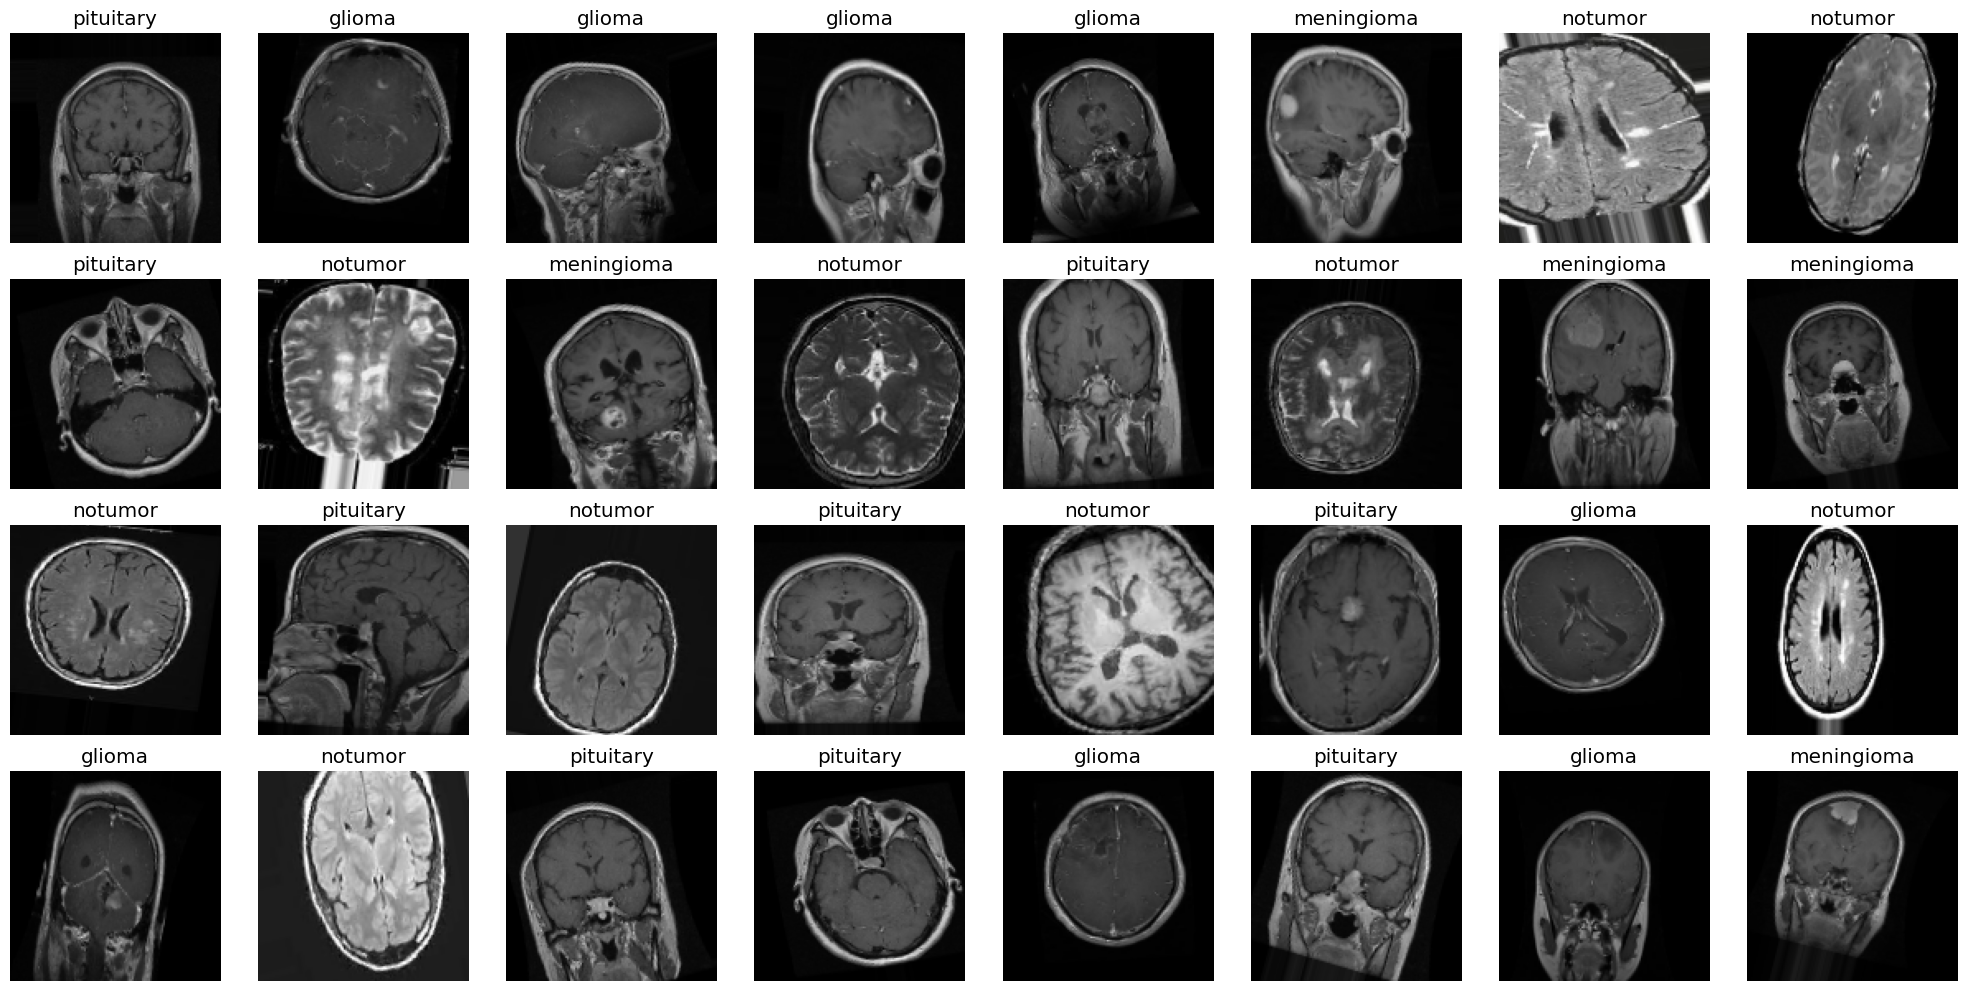

In [22]:
# Take one batch
images, labels = next(train_generator)

print("Batch images shape:", images.shape)
print("Batch labels shape:", labels.shape)

# Show the batch
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i])  # float images already in [0,1], so no need to cast
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [23]:
#CNN Model
model = models.Sequential([
    # 1st Convolutional Block
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # 2nd Convolutional Block
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # 3rd Convolutional Block
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # 4th Convolutional Block
    layers.Conv2D(256, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Flatten + Dense
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(4, activation="softmax")  # 4 classes
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_cnn_model.keras", save_best_only=True),
    reduce_lr]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6902 - loss: 0.7781 - val_accuracy: 0.2314 - val_loss: 4.5201 - learning_rate: 1.0000e-04
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 140s 977ms/step - accuracy: 0.7683 - loss: 0.5787 - val_accuracy: 0.3120 - val_loss: 2.0014 - learning_rate: 1.0000e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 140s 979ms/step - accuracy: 0.7898 - loss: 0.5321 - val_accuracy: 0.4566 - val_loss: 1.3910 - learning_rate: 1.0000e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 935ms/step - accuracy: 0.7998 - loss: 0.5043 - val_accuracy: 0.5504 - val_loss: 1.1625 - learning_rate: 1.0000e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 139s 974ms/step - accuracy: 0.8197 - loss: 0.4539 - val_accuracy: 0.7458 - val_loss: 0.7200 - learning_rate: 1.0000e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 139s 974ms/step - accuracy: 0.8263 - loss: 0.4391 - val_accuracy: 0.7344 - val_loss: 0.7132 - learning_rate: 1.0000e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 140

In [27]:
# Evaluation
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.8314 - loss: 0.5171 
Test Accuracy: 83.14%


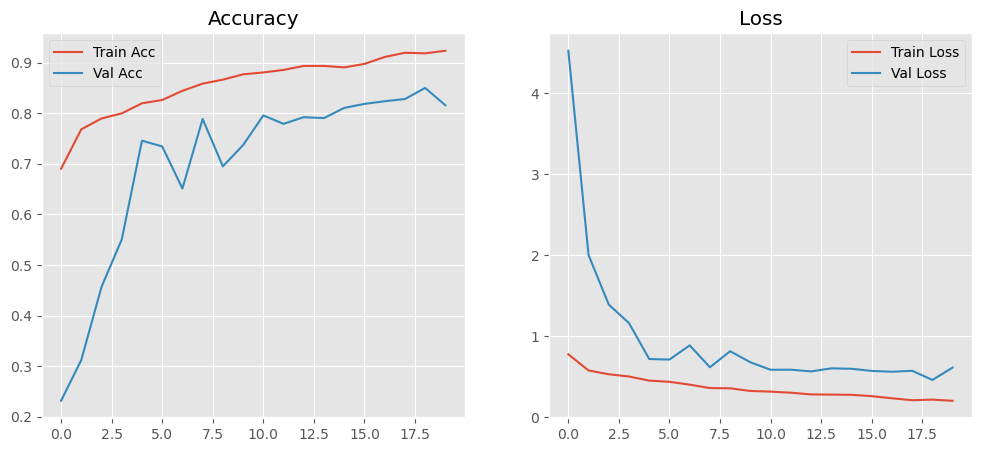

In [28]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [29]:
# Confusion Matrix & Report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:\n", classification_report(
    test_generator.classes, y_pred_classes,
    target_names=list(test_generator.class_indices.keys())
))

cm = confusion_matrix(test_generator.classes, y_pred_classes)
print("Confusion Matrix:\n", cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.77      0.84       300
  meningioma       0.86      0.52      0.64       306
     notumor       0.83      0.99      0.90       405
   pituitary       0.75      1.00      0.86       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.81      1311
weighted avg       0.84      0.83      0.82      1311

Confusion Matrix:
 [[231  26   5  38]
 [ 13 158  76  59]
 [  3   0 401   1]
 [  0   0   0 300]]
